### Clustering of the AP3 fingerprints to evaluate the applicability for similarity search

In [22]:
import _pickle as cPickle
import gzip,time
from collections import defaultdict
import random
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs
import utilsFunctions
from pylab import rcParams


Choose some larger text size in the plots

In [2]:
rcParams.update({'font.size': 14})

In [4]:
dataDir = "../data/"

with open(dataDir+"reactionTypes_training_test_set_patent_data.pkl",'rb') as f:
    reaction_types = cPickle.load(f)
with open(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl",'rb') as f:
    names_rTypes = cPickle.load(f)

# reaction_types = cPickle.load(file(dataDir+"reactionTypes_training_test_set_patent_data.pkl"))
# names_rTypes = cPickle.load(file(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl"))

Load the transformation FPs 

In [6]:
infile = gzip.open(dataDir+"transformationFPs_test_set_patent_data.pkl.gz", 'rb')

lineNo=0
fps=[]
idx=0
while 1:
    lineNo+=1
    try:
        lbl,cls,fp_AP3,fp_MG2,fp_TT = cPickle.load(infile)        
    except EOFError:
        break
    fps.append([idx,lbl,cls,fp_AP3])
    idx+=1
    if not lineNo%10000:
        print("Done "+str(lineNo))

Done 10000
Done 20000
Done 30000
Done 40000


Build a subset of the fingerprints (training set) (10000 FPs) for efficiency reasons.

In [7]:
random.seed(0xd00f)
indices=list(range(len(fps)))
random.shuffle(indices)

nActive=200
fpsz= 256
fpsubset = []

rtypes=sorted(list(reaction_types))
for i,klass in enumerate(rtypes):
    actIds = [x for x in indices if fps[x][2]==klass]
    for x in actIds[:nActive]:
        trfp_AP3 = utilsFunctions.hashFP(fps[x][3],fpsz)
        trfp_AP3 = utilsFunctions.removeNegativeCountsFP(trfp_AP3)
        fpsubset.append((trfp_AP3,fps[x][2]))

Cluster this subset using the Butina algorithm from the RDKit with the Dice coefficent as similiarty metric and a threshold of 0.5 for similar FPs.

58.92
649


(array([588.,  22.,  12.,   9.,   4.,   1.,   5.,   0.,   0.,   2.,   1.,
          0.,   1.,   1.,   0.,   0.,   1.,   1.,   0.,   1.]),
 array([  1. ,  31.1,  61.2,  91.3, 121.4, 151.5, 181.6, 211.7, 241.8,
        271.9, 302. , 332.1, 362.2, 392.3, 422.4, 452.5, 482.6, 512.7,
        542.8, 572.9, 603. ]),
 <BarContainer object of 20 artists>)

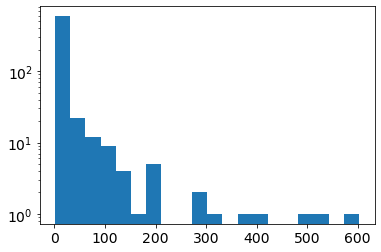

In [12]:
t1=time.time()
tf=[x[0] for x in fpsubset]
cs = Butina.ClusterData(tf,len(tf),0.5,distFunc=lambda x,y:1.-DataStructs.DiceSimilarity(x,y))
t2=time.time()

print('%.2f'%(t2-t1))
print(len(cs))




(array([588.,  22.,  12.,   9.,   4.,   1.,   5.,   0.,   0.,   2.,   1.,
          0.,   1.,   1.,   0.,   0.,   1.,   1.,   0.,   1.]),
 array([  1. ,  31.1,  61.2,  91.3, 121.4, 151.5, 181.6, 211.7, 241.8,
        271.9, 302. , 332.1, 362.2, 392.3, 422.4, 452.5, 482.6, 512.7,
        542.8, 572.9, 603. ]),
 <BarContainer object of 20 artists>)

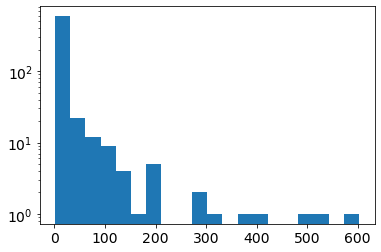

In [13]:
plt.hist([len(x) for x in cs],bins=20,log=True)

Determine the purity of the clusters with at least ten members. The purity of the cluster is calculated by determining the main reaction type, class and super-class and normalizing this quantity by the size of the cluster.

In [14]:
import operator
purities=[]
nAccountedFor=0
for (i,c) in enumerate(cs):
    sz=len(c)
    if sz<=10:
        continue
    nAccountedFor+=sz
    tcounts1=defaultdict(int)
    tcounts2=defaultdict(int)
    tcounts3=defaultdict(int)
    for idx in c:
        lbl = fpsubset[idx][1]
        slbl = lbl.split(' ')[0].split('.')
        tcounts1[slbl[0]]+=1
        tcounts2['.'.join(slbl[:2])]+=1
        tcounts3['.'.join(slbl[:3])]+=1
        
    tcounts1_sorted = sorted(tcounts1.items(), key=operator.itemgetter(1), reverse=True) 
    maxc1 = tcounts1_sorted[0][1]
    maxlbl1 = tcounts1_sorted[0][0]
    tcounts2_sorted = sorted(tcounts2.items(), key=operator.itemgetter(1), reverse=True) 
    maxc2 = tcounts2_sorted[0][1]
    maxlbl2 = tcounts2_sorted[0][0]
    tcounts3_sorted = sorted(tcounts3.items(), key=operator.itemgetter(1), reverse=True) 
    maxc3 = tcounts3_sorted[0][1]
    maxlbl3 = tcounts3_sorted[0][0]
    purities.append((i,sz,(1.*maxc1/sz,1.*maxc2/sz,1.*maxc3/sz),(maxlbl1, maxlbl2, maxlbl3),(maxc1,maxc2,maxc3)))
print(len(purities),nAccountedFor)

117 8729


Determine the number of members per reaction type, class and super-class in the FP subset.

In [15]:
members_rtype=defaultdict(int)
members_class=defaultdict(int)
members_superclass=defaultdict(int)
for i in fpsubset:
    members_rtype[i[1]]+=1
    members_class[i[1].split('.')[0]+'.'+i[1].split('.')[1]]+=1
    members_superclass[i[1].split('.')[0]]+=1

##### Calculate F-score, precision and recall for the reaction type purity of the clusters.

The mean purity per reaction type can be regarded as a kind of precision value. We were also interested in the recall, the number of reactions per reaction type which could be actually recovered within the clusters. Hence, the recall is calculated by the number of recovered reactions divided by number of reactions of that type contained in the data. Using the recall and precision the F-score of the clustering for each reaction type can be determined.

Merge the clusters with the same main reaction type and calculate based on this the mean F-score, precision and recall.

In [16]:
# input purities list of the Butina clustering, number of members dict per reation type, class or super-class
# level: super-class = 0, class = 1, reation type = 2 
rtype_purity_dict = utilsFunctions.evaluatePurityClusters(purities, members_rtype, 2)

Mean F-score:  0.6187263649772858
Median F-score:  0.5705539057355002
Min, Max F-score : 0.9847715736040609 0.04672897196261683
Mean precision:  0.7438759337531148
Median precision:  0.7949858757062147
Min, Max precision : 1.0 0.2833440790887599
Mean recall:  0.6006521739130435
Median recall:  0.6675
Min, Max recall : 1.0 0.025


Sort the final clusters based on the number of clusters they were build of in ascending order.

In [17]:
rtype_purity_sorted = sorted(rtype_purity_dict.items(), key=operator.itemgetter(1))

Plot the distribution of the different reaction type clusters considering the number of clusters they were build of and their F-score. 

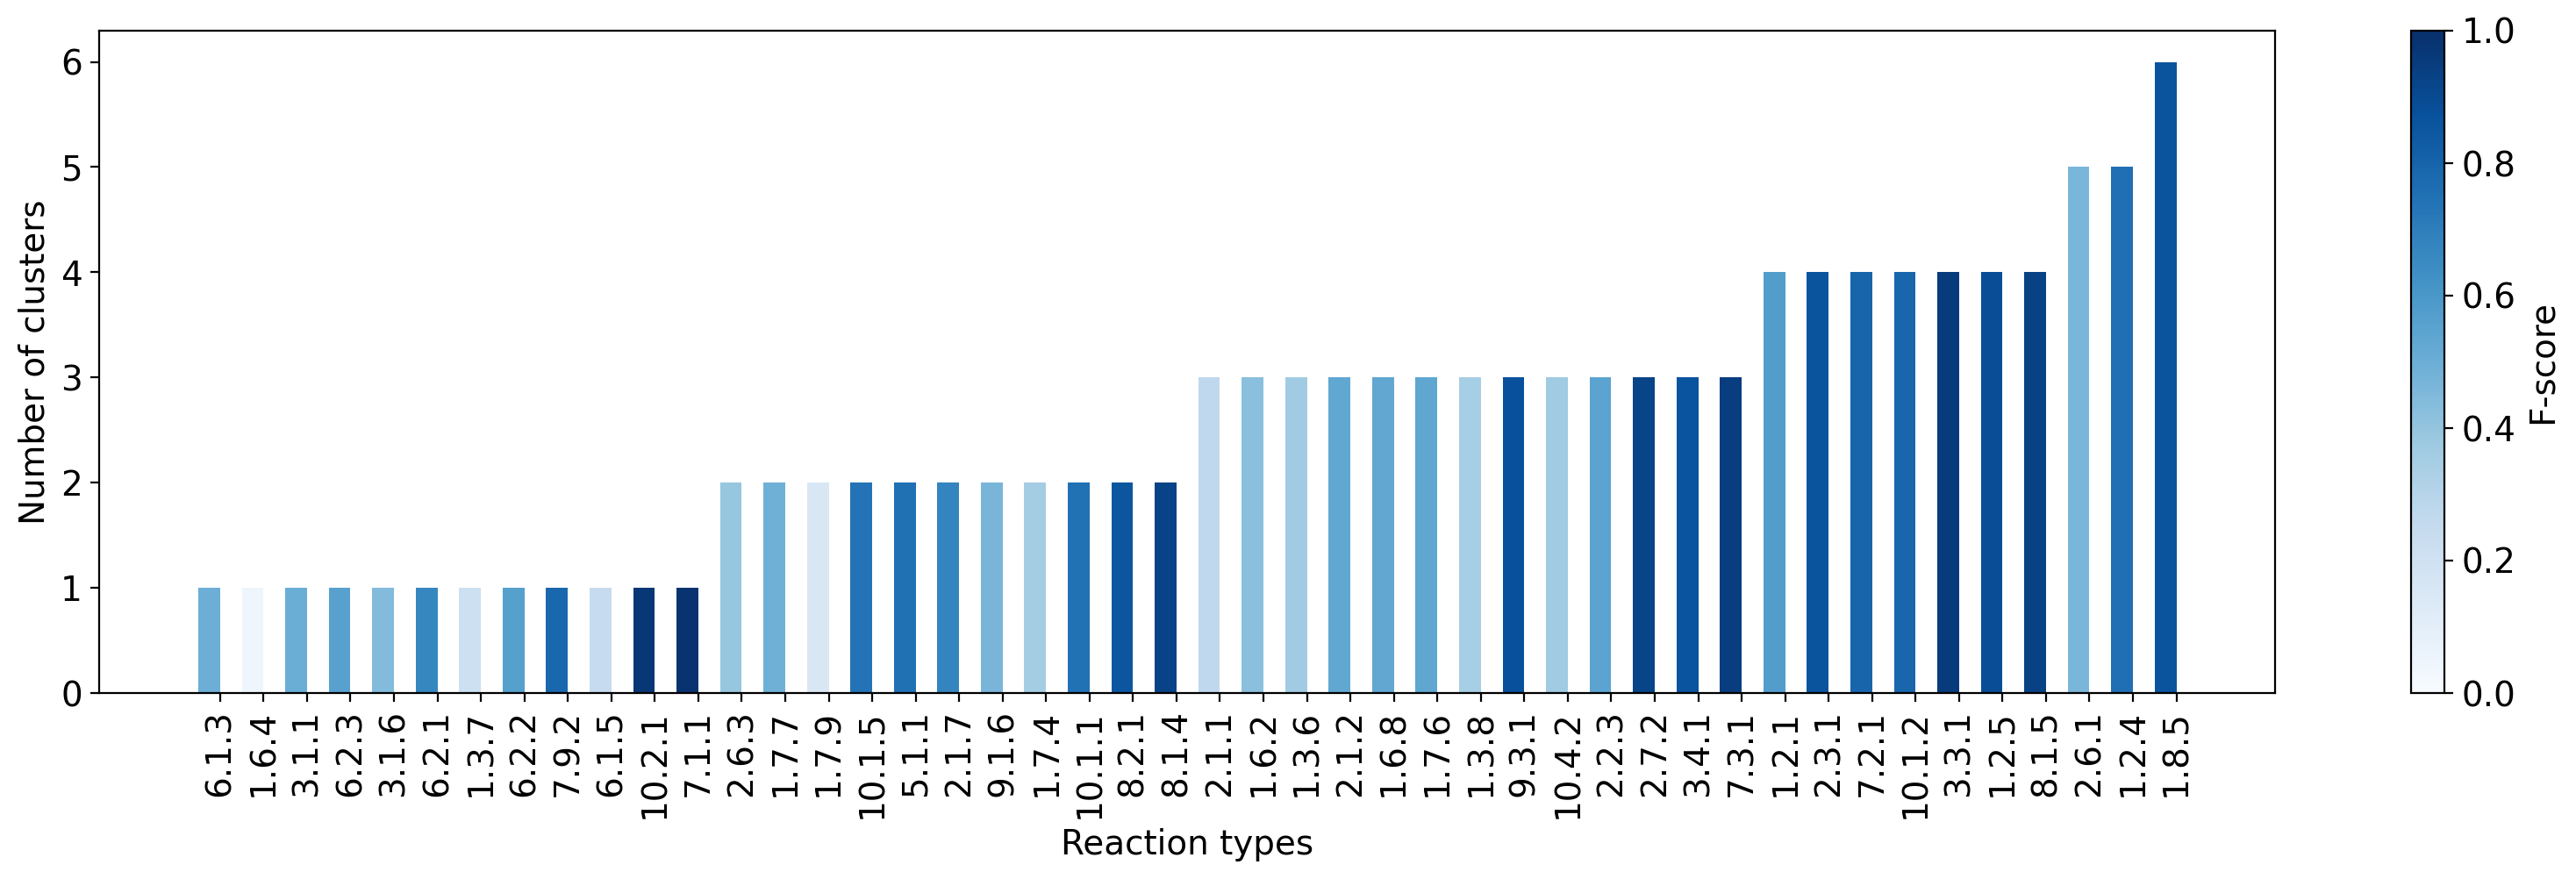

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

labels = [x[0] for x in rtype_purity_sorted]
yvalues1 = [x[1][0] for x in rtype_purity_sorted]
colors = [x[1][5] for x in rtype_purity_sorted]

xvalues = np.arange(len(rtype_purity_sorted))
colors.append(1.0) # to a scale from 0.0. to 1.0
colors.append(0.0) # to a scale from 0.0. to 1.0

width = 0.5
plt.figure(1,figsize=(20,5),dpi=200)
plt.subplot(1,1,1)
plt.bar(xvalues, yvalues1,width,color=plt.cm.Blues(colors))
plt.xticks(xvalues+width/2., labels,rotation='vertical')
plt.ylabel('Number of clusters')
plt.xlabel('Reaction types')
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues)
sm.set_array(colors)
cb = plt.colorbar(sm)
cb.set_label('F-score')

Merge the clusters with the same main reaction class and calculate based on this the mean F-score, precision and recall.

In [33]:
# input purities list of the Butina clustering, number of members dict per reation type, class or super-class
# level: super-class = 0, class = 1, reation type = 2 
class_purity_dict = utilsFunctions.evaluatePurityClusters(purities, members_class, 1)

Mean F-score:  0.7659858039381506
Median F-score:  0.7884672315361613
Min, Max F-score : 0.9847715736040609 0.36911667122057845
Mean precision:  0.8839696538394836
Median precision:  0.8924050632911392
Min, Max precision : 1.0 0.6551079247506982
Mean recall:  0.7130401234567901
Median recall:  0.76
Min, Max recall : 0.99 0.235


Sort the final clusters based on their mean F-score in ascending order.

In [34]:
class_purity_sorted = sorted(class_purity_dict.items(), key=lambda x: x[1][5])

Plot the distribution of the different reaction class clusters their mean F-score. 

Text(0.5, 0, 'Reaction classes')

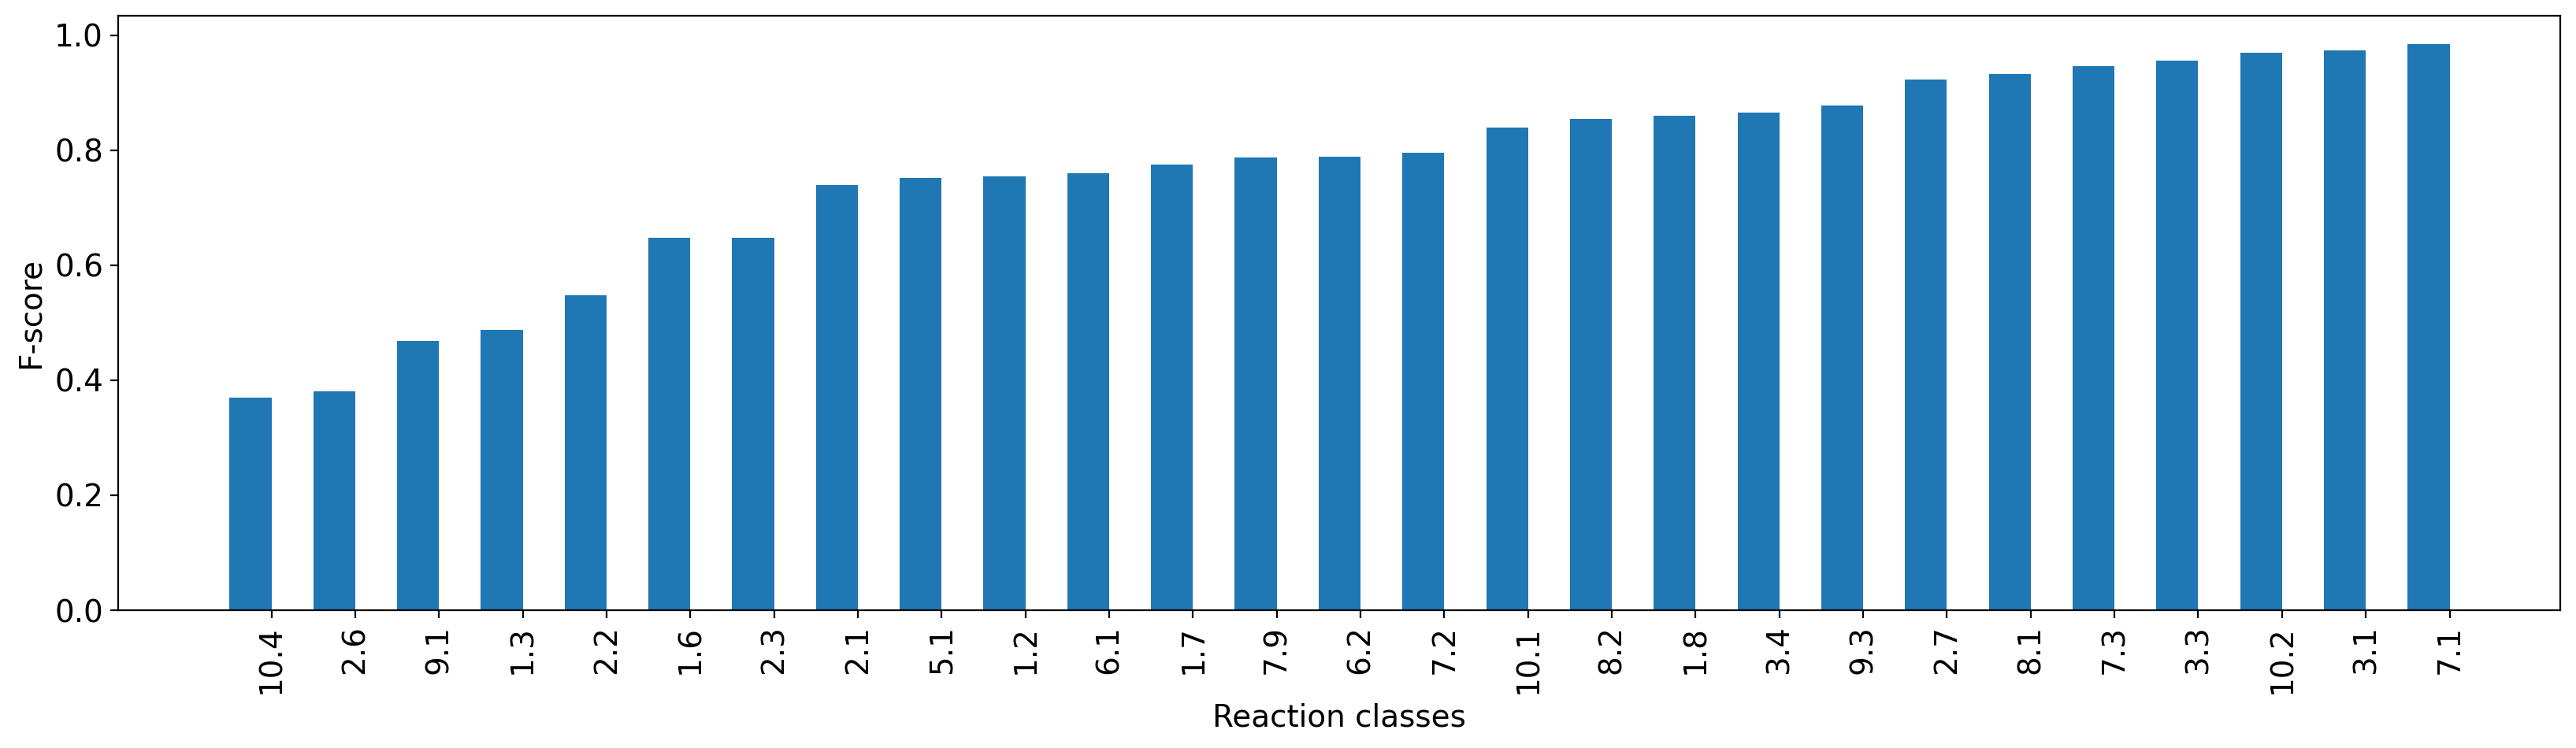

In [36]:
labels = [x[0] for x in class_purity_sorted]
yvalues1 = [x[1][5] for x in class_purity_sorted]
colors = [x[1][5] for x in class_purity_sorted]
xvalues = np.arange(len(class_purity_sorted))
colors.append(1.0) # to a scale from 0.0. to 1.0
colors.append(0.0) # to a scale from 0.0. to 1.0

width = 0.5
plt.figure(1,figsize=(20,5),dpi=200)
plt.subplot(1,1,1)
plt.bar(xvalues, yvalues1,width)#,color=cm.Blues(colors))
plt.xticks(xvalues+width/2., labels,rotation='vertical')
plt.ylabel('F-score')
plt.xlabel('Reaction classes')

Merge the clusters with the same main reaction super-class and calculate based on this the mean F-score, precision and recall.

In [37]:
# input purities list of the Butina clustering, number of members dict per reation type, class or super-class
# level: super-class = 0, class = 1, reation type = 2 
superclass_purity_dict = utilsFunctions.evaluatePurityClusters(purities, members_superclass, 0)

Mean F-score:  0.8727580207130221
Median F-score:  0.9071038251366119
Min, Max F-score : 0.9690181426592385 0.7515675918642544
Mean precision:  0.9364467343308989
Median precision:  0.970541057161998
Min, Max precision : 1.0 0.7983050847457627
Mean recall:  0.8202638888888889
Median recall:  0.83
Min, Max recall : 0.9675 0.7


Sort the final clusters based on their mean F-score in ascending order.

In [38]:
superclass_purity_sorted = sorted(superclass_purity_dict.items(), key=lambda x: x[1][5])

Plot the distribution of the different reaction super-class clusters their mean F-score. 

Text(0.5, 0, 'Reaction super-classes')

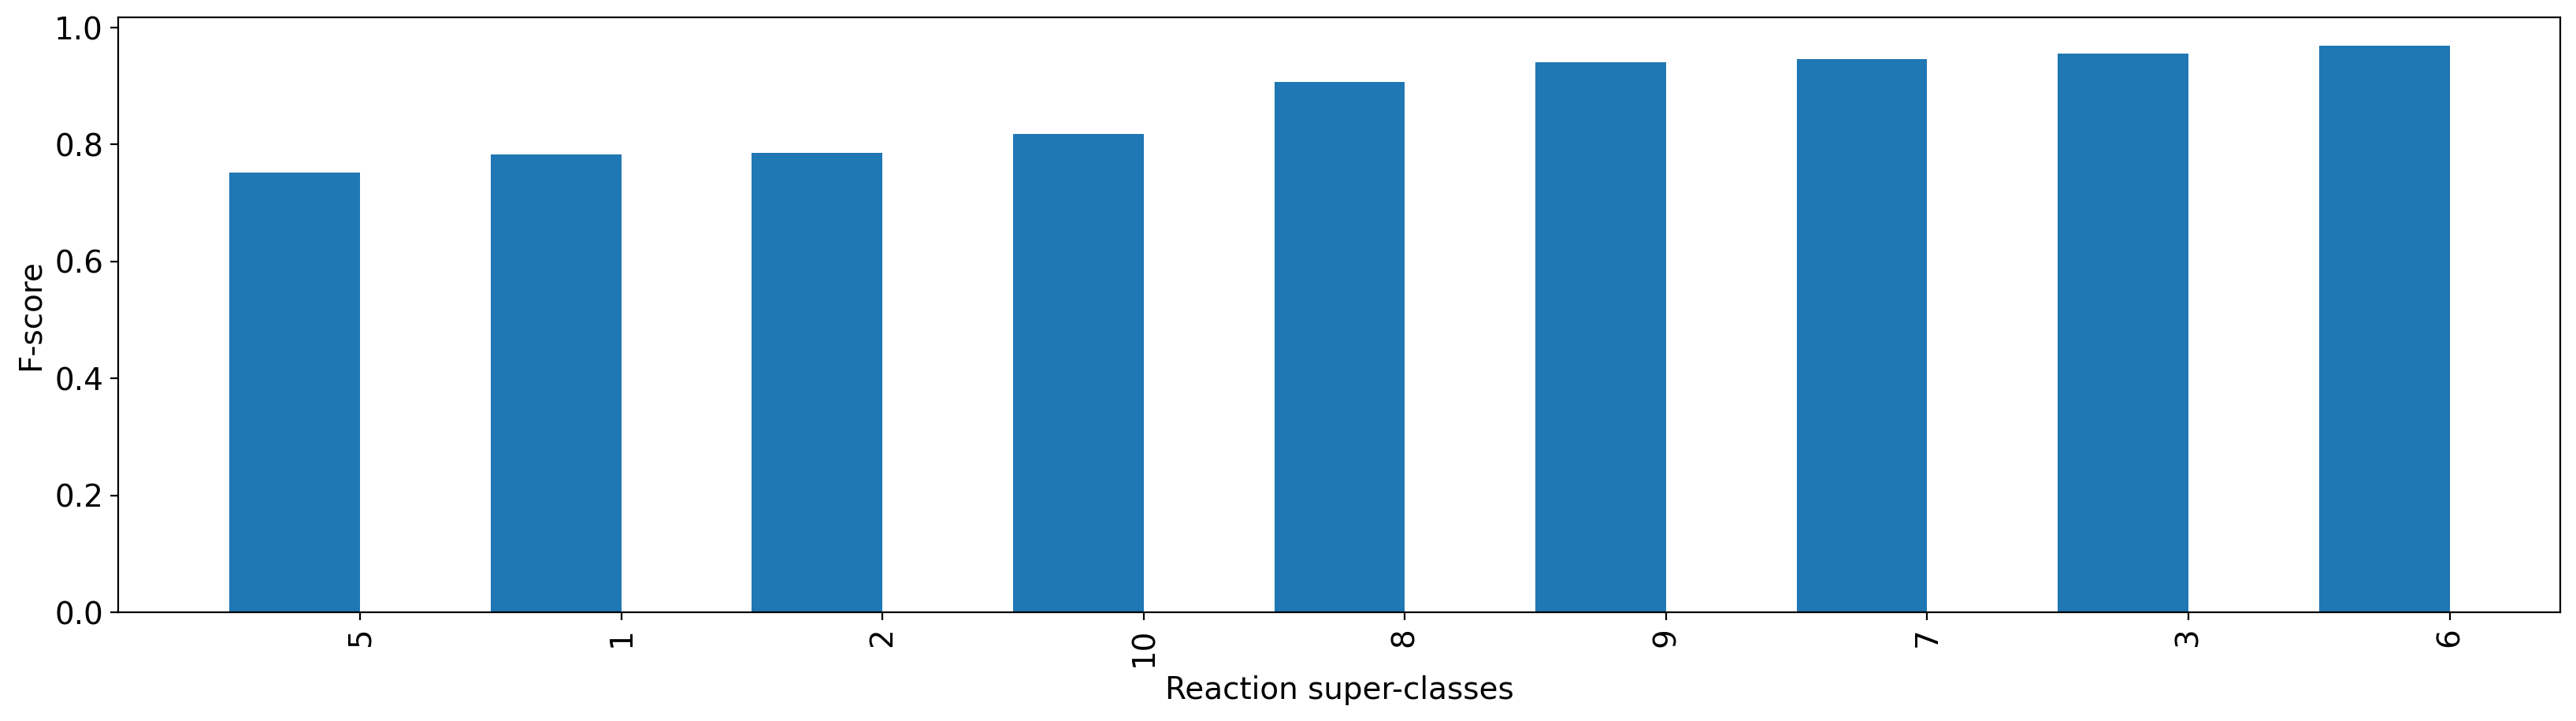

In [39]:
labels = [x[0] for x in superclass_purity_sorted]
yvalues1 = [x[1][5] for x in superclass_purity_sorted]
colors = [x[1][5] for x in superclass_purity_sorted]

xvalues = np.arange(len(superclass_purity_sorted))
colors.append(1.0) # to a scale from 0.0. to 1.0
colors.append(0.0) # to a scale from 0.0. to 1.0

width = 0.5
plt.figure(1,figsize=(20,5),dpi=200)
plt.subplot(1,1,1)
plt.bar(xvalues, yvalues1,width)#,color=cm.Blues(colors))
plt.xticks(xvalues+width/2., labels,rotation='vertical')
plt.ylabel('F-score')
plt.xlabel('Reaction super-classes')